In [1]:
import warnings
warnings.filterwarnings('ignore')

# Model fitting 3:  External Compton 

## Loading data

In [2]:
from jetset.jet_model import Jet
from jetset.data_loader import Data,ObsData
from jetset.test_data_helper import  test_SEDs
test_SEDs


['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

In [3]:
data=Data.from_file(test_SEDs[0])


In [4]:
sed_data=ObsData(data_table=data)

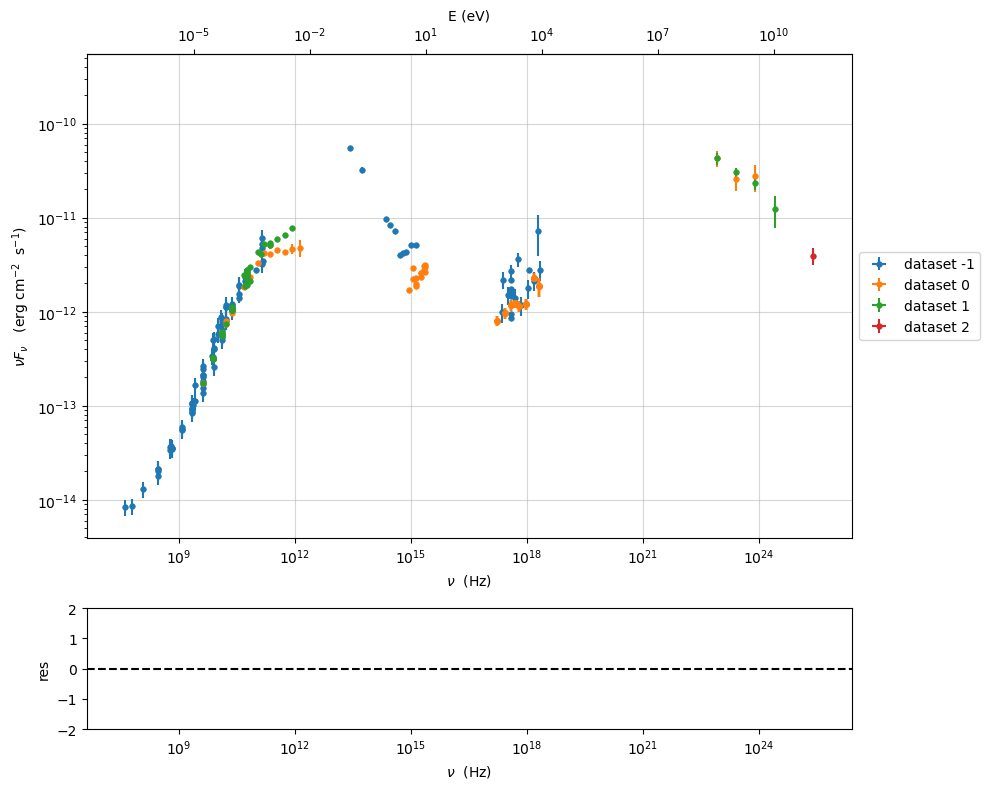

In [5]:
%matplotlib inline
p=sed_data.plot_sed(show_dataset=True)

we filter out the data set `-1` 

current datasets
dataset -1
dataset 0
dataset 1
dataset 2
---> excluding  data_set/s ['-1']
filter -1 192
current datasets
dataset 0
dataset 1
dataset 2
---> data sets left after filtering None
---> data len after filtering=192
current datasets
dataset 0
dataset 1
dataset 2


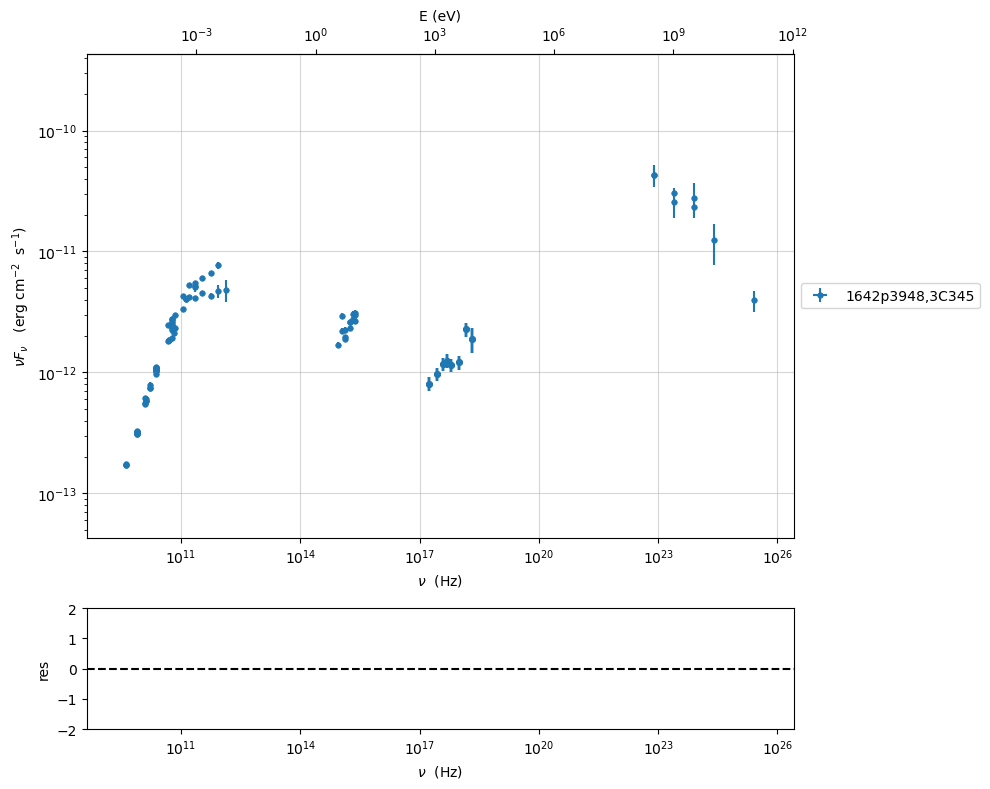

In [6]:
sed_data.show_data_sets()
sed_data.filter_data_set('-1',exclude=True)
sed_data.show_data_sets()
p=sed_data.plot_sed()



***  binning data  ***
---> N bins= 80
---> bin_widht= 0.2



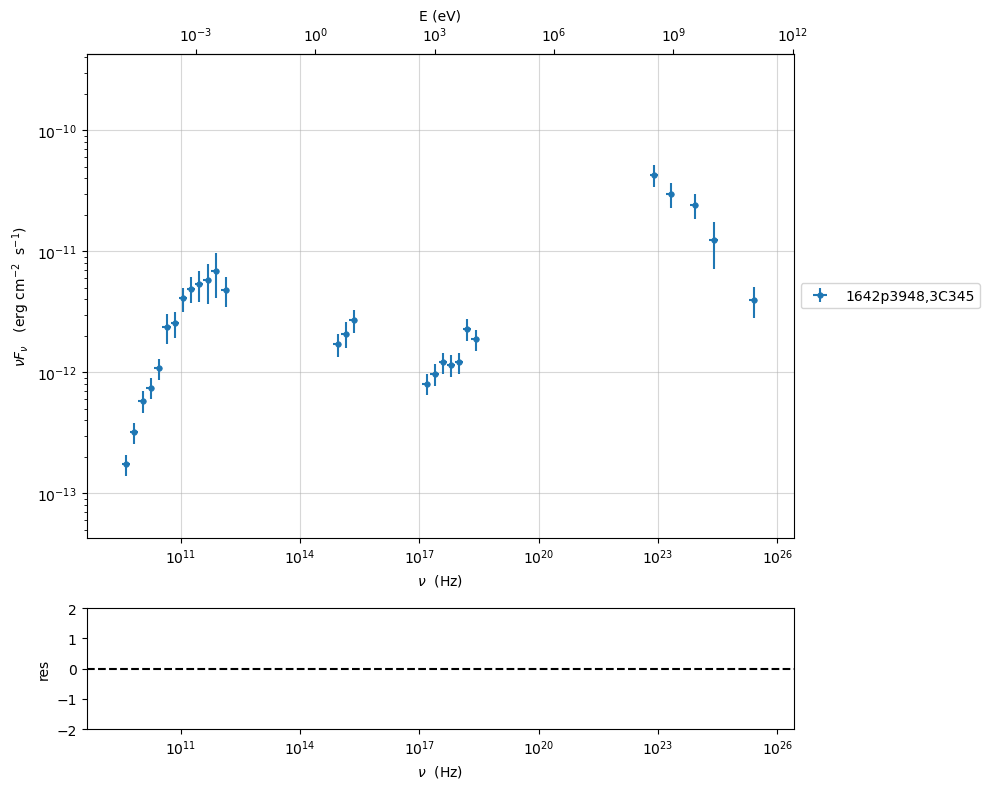

In [7]:
sed_data.group_data(bin_width=.2)
sed_data.add_systematics(0.2,[10.**6,10.**29])
p=sed_data.plot_sed()

In [8]:
sed_data.save('3C454_data.pkl')

## Phenomenological model constraining


*** evaluating spectral indices for data ***



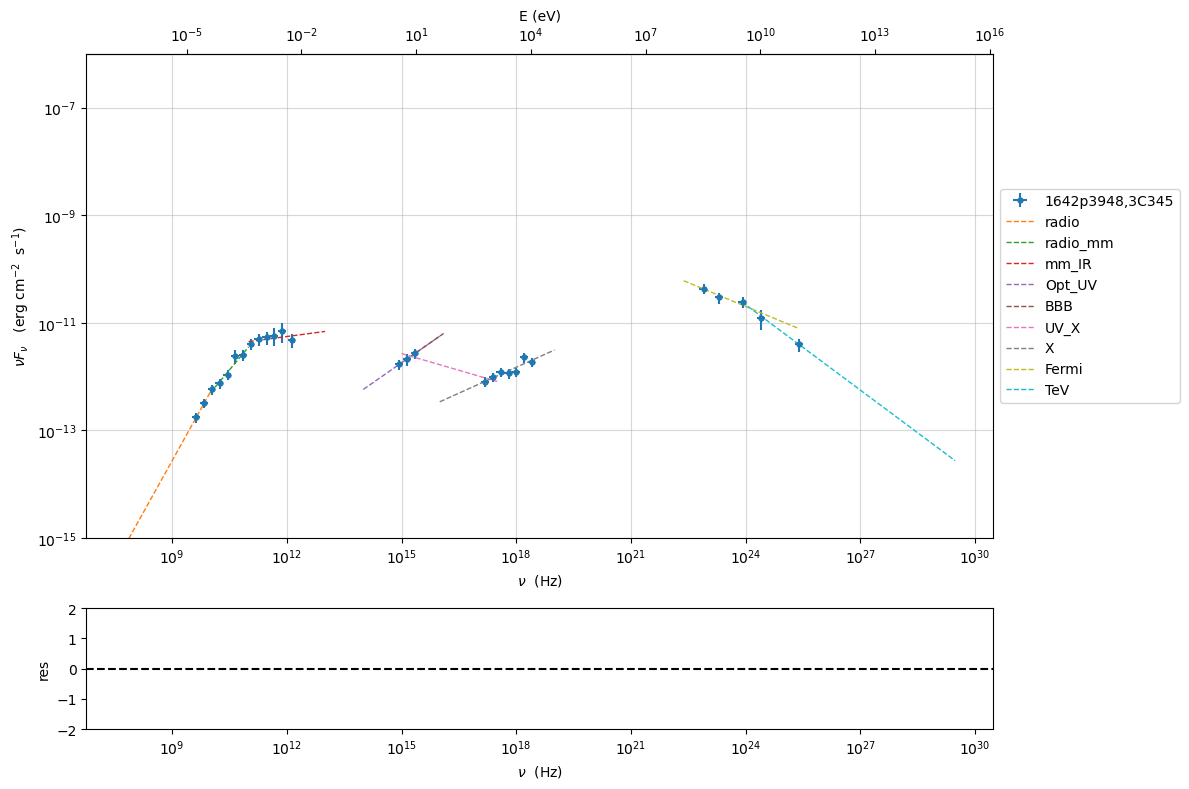

In [9]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

for the synchrotron sed_shaping we include the check for Big Blue Bump (BBB) component. Moreover, we force the model to use a pure log-parabolic function and not a log-cubic one in order to get a better estimation of the BBB  component. The fit values of the BBB component will be used in the `ObsConstrain` to guess the accretion disk luminosity and temperature

In [10]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

--> class:  LSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogParabolaEp,b,-2.984653e-01,-2.984653e-01,5.631694e-02,--,-1.527892e-01,-1.000000e+01,0.000000e+00,False
LogParabolaEp,Ep,1.190850e+01,1.190850e+01,2.238841e-01,--,1.298338e+01,0.000000e+00,3.000000e+01,False
LogParabolaEp,Sp,-1.123366e+01,-1.123366e+01,7.306404e-02,--,-1.095506e+01,-3.000000e+01,0.000000e+00,False
BBB,nuFnu_p_BBB,-1.155965e+01,-1.155965e+01,6.791135e-02,--,-1.095506e+01,-1.295506e+01,-8.955061e+00,False
BBB,nu_scale,7.058302e-02,7.058302e-02,2.539034e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.190850e+01 (err=+2.238841e-01)  nuFnu_p=-1.123366e+01 (err=+7.306404e-02) curv.=-2.984653e-01 (err=+5.631694e-02)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.128855e-01,-1.128855e-01,1.240849e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.065003e-02,-1.065003e-02,2.393721e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.273378e+01,2.273378e+01,1.453319e-01,--,2.270678e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.043090e+01,-1.043090e+01,6.087264e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.273378e+01 (err=+1.453319e-01)  nuFnu_p=-1.043090e+01 (err=+6.087264e-02) curv.=-1.128855e-01 (err=+1.240849e-02)



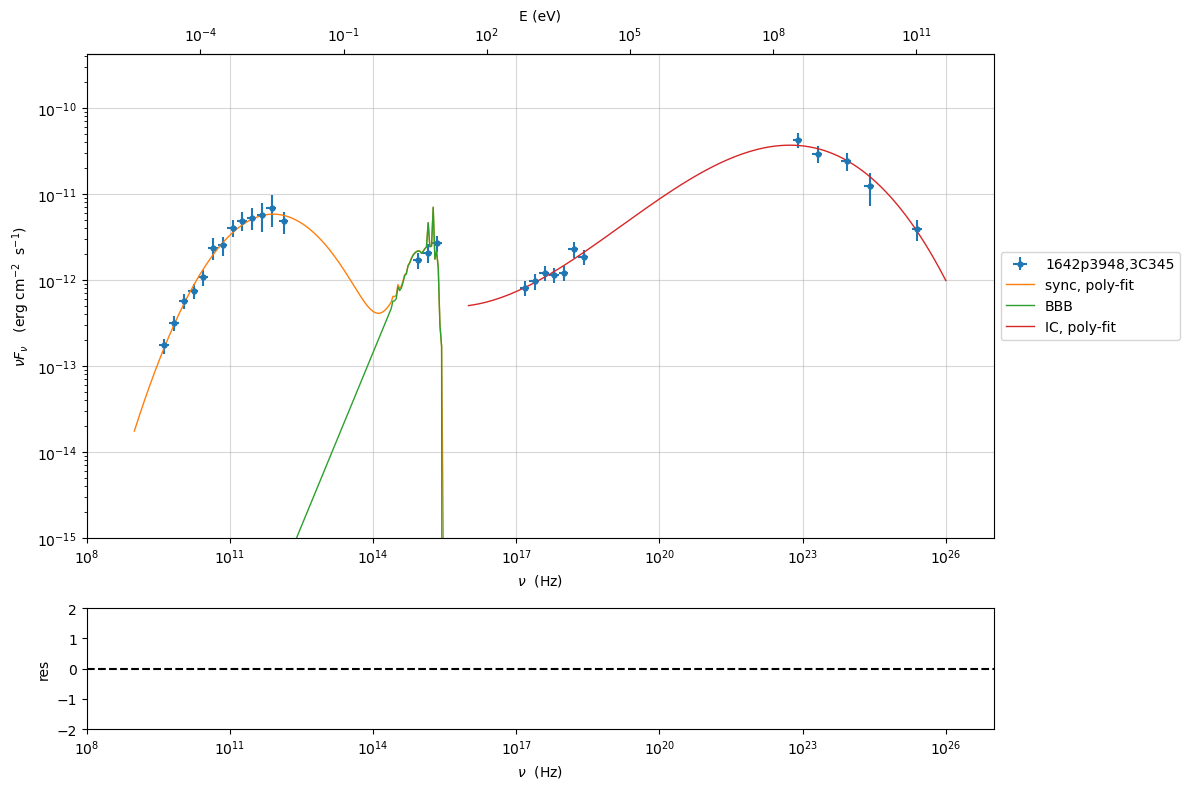

In [11]:
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

In this case we use the `constrain_SSC_EC_model`, and we ask to use a dusty torus and BLR component external component

In [12]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.1,0.2],
                        distr_e='bkn',
                        t_var_sec=7*86400,
                        nu_cut_IR=1E9,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,EC_componets_list=['EC_DT','EC_BLR'],R_H=1E18,silent=True)



***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,2.845488e+17,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+18,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.500000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,5.930000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.071498e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.601124e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.846756e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.049588e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.357911e+00,-1.000000e+01,1.000000e+01,False,False


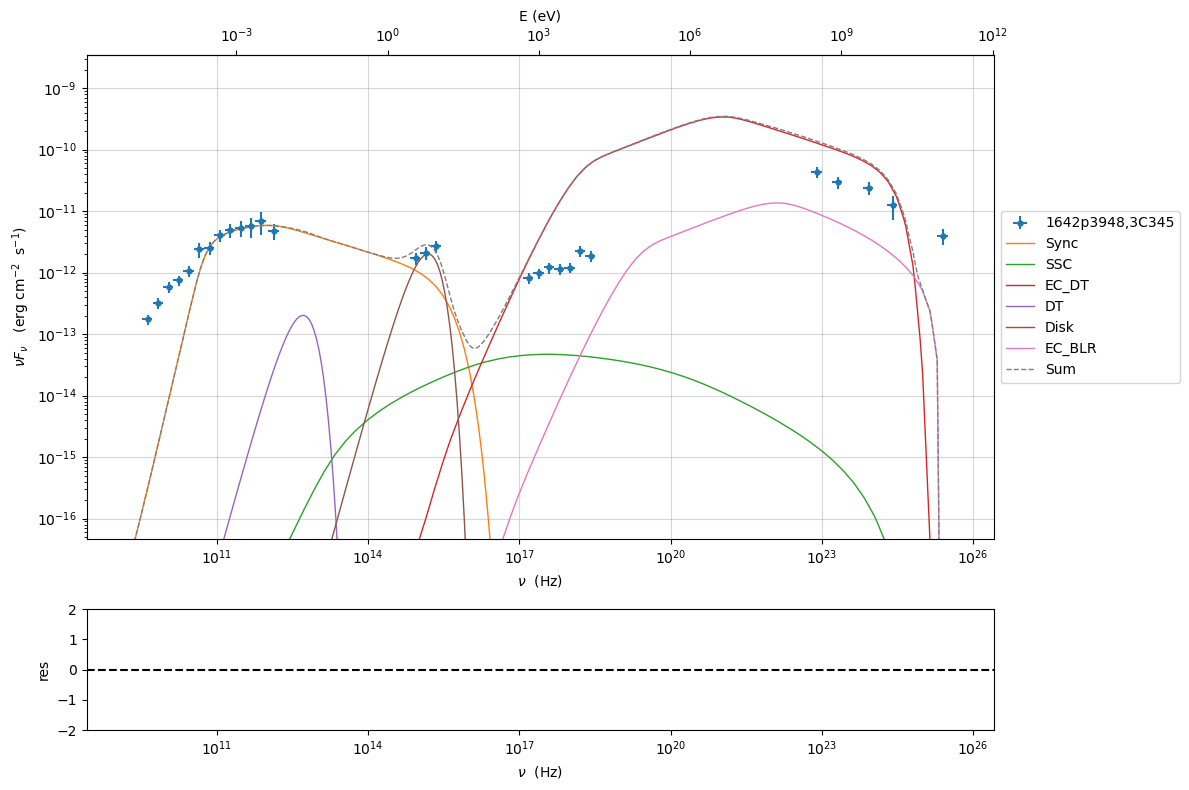

In [13]:
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)
prefit_jet.save_model('prefit_jet_EC.pkl')

The prefit model should works well for the synchrotron component, but the EC one is a bit problematic. We can set as starting values  a slightly harder value of `p`, and a larger value of `gamma_break` and `gmax`. We freeze some parameters, and we also set some `fit_range` values. Setting fit_range can speed-up the fit convergence but should be judged by the user each time according to the physics of the particular source

## EC model fit

In [14]:
jet=Jet.load_model('prefit_jet_EC.pkl')
jet.set_gamma_grid_size(100)
fit_model=FitModel( jet=jet, name='EC-best-fit-lsb')
fit_model.show_model_components()

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.071498e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.601124e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.846756e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.049588e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.357911e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,1.000000e+02,0.000000e+00,--,False,False
jet_leptonic,R_DT,DT,cm,5.143375e+18,0.000000e+00,--,False,False
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,False
jet_leptonic,tau_BLR,BLR,,1.000000e-01,0.000000e+00,1.000000e+00,False,False



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: EC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


In [15]:

fit_model.freeze('jet_leptonic','z_cosm')
fit_model.free('jet_leptonic','R_H')
fit_model.freeze('jet_leptonic','L_Disk')
fit_model.freeze('jet_leptonic','R_DT')
fit_model.freeze('jet_leptonic','R_BLR_in')
fit_model.freeze('jet_leptonic','R_BLR_out')

fit_model.jet_leptonic.parameters.R.fit_range=[1E16,5E18]
fit_model.jet_leptonic.parameters.gamma_break.fit_range=[300,3000]
fit_model.jet_leptonic.parameters.gmin.fit_range=[2,100]
fit_model.jet_leptonic.parameters.gmax.fit_range=[1000,1E6]

In [16]:
from jetset.minimizer import ModelMinimizer
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model,sed_data,1E11,1E29,fitname='EC-best-fit-lsb',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 21

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.93395e+01

fit run: 1
- old chisq=1.93395e+01


0it [00:00, ?it/s]

- best chisq=1.93395e+01

fit run: 2
- old chisq=1.93395e+01


0it [00:00, ?it/s]

- best chisq=1.93386e+01

-------------------------------------------------------------------------
Fit report

Model: EC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.297117e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.822712e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.258362e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.008818e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.034138e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.639483e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,4.580689e+02,0.000000e+00,--,False,False
jet_leptonic,R_DT,DT,cm,5.143375e+18,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.781413e-01,0.000000e+00,1.000000e+00,False,False
jet_leptonic,tau_BLR,BLR,,2.089862e-04,0.000000e+00,1.000000e+00,False,False



converged=True
calls=131
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=7
chisq=19.338558, chisq/red=2.762651 null hypothesis sig=0.007190

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.297117e+00,4.297117e+00,3.882204e+01,--,1.071498e+01,2.000000e+00,1.000000e+02,False
jet_leptonic,gmax,2.822712e+04,2.822712e+04,6.287440e+04,--,1.601124e+04,1.000000e+03,1.000000e+06,False
jet_leptonic,N,2.258362e+01,2.258362e+01,3.495097e+01,--,1.846756e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,3.008818e+02,3.008818e+02,9.752563e+01,--,3.049588e+02,3.000000e+02,3.000000e+03,False
jet_leptonic,p,1.034138e+00,1.034138e+00,8.354114e-01,--,2.357911e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,3.639483e+00,3.639483e+00,5.168124e-01,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,T_DT,4.580689e+02,4.580689e+02,5.222955e+03,--,1.000000e+02,0.000000e+00,--,False
jet_leptonic,R_DT,5.143375e+18,--,--,--,5.143375e+18,0.000000e+00,--,True
jet_leptonic,tau_DT,1.781413e-01,1.781413e-01,3.296905e+00,--,1.000000e-01,0.000000e+00,1.000000e+00,False
jet_leptonic,tau_BLR,2.089862e-04,2.089862e-04,2.564684e+04,--,1.000000e-01,0.000000e+00,1.000000e+00,False


-------------------------------------------------------------------------




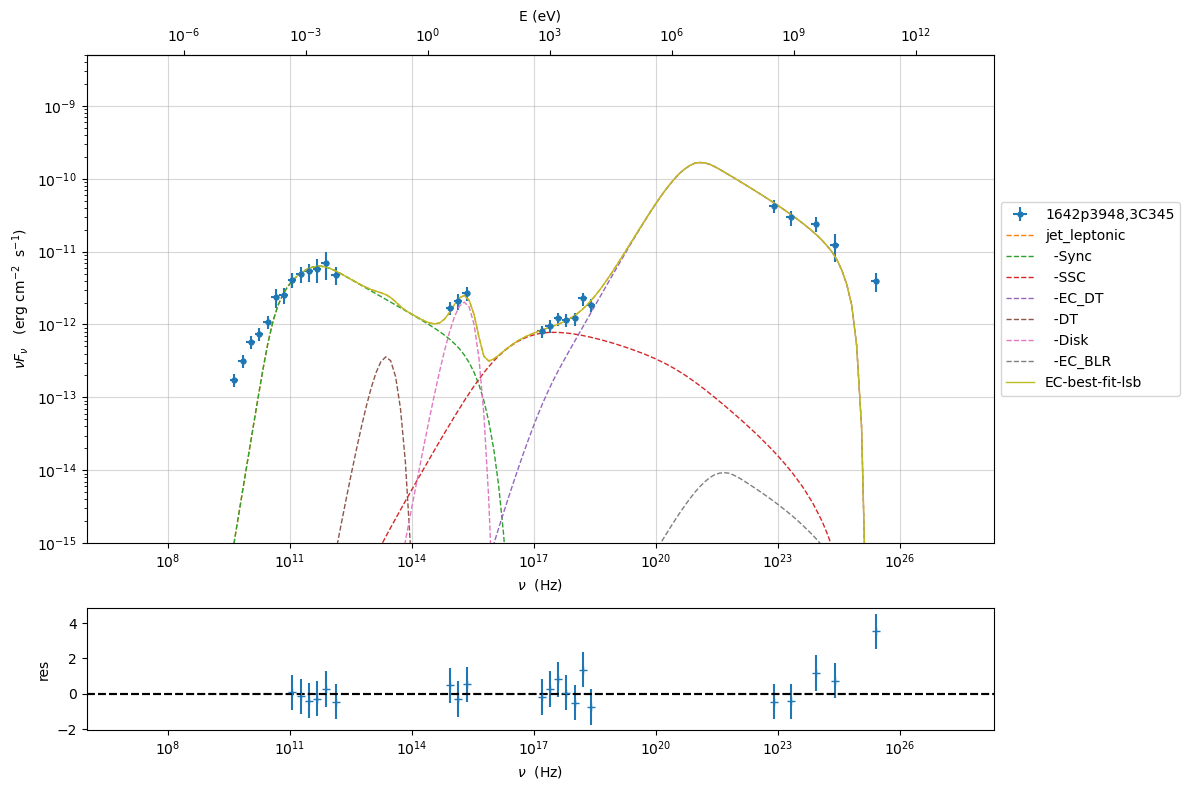

In [17]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-15,y_max=5E-9,x_min=1E6,x_max=2E28)

In [18]:
from jetset.minimizer import ModelMinimizer
model_minimizer_minuit=ModelMinimizer('minuit')
fit_model.freeze('jet_leptonic','R_H')
fit_model.jet_leptonic.parameters.gmax.val=1E5
best_fit_minuit=model_minimizer_minuit.fit(fit_model,sed_data,1E11,1E29,fitname='EC-best-fit-minuit',repeat=2)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 21

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.16376e+01

fit run: 1
- old chisq=1.16376e+01


0it [00:00, ?it/s]

- best chisq=1.05577e+01

-------------------------------------------------------------------------
Fit report

Model: EC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.295675e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.002469e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.257972e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,3.008410e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.036353e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.604263e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,4.431086e+02,0.000000e+00,--,False,False
jet_leptonic,R_DT,DT,cm,5.143375e+18,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.761708e-01,0.000000e+00,1.000000e+00,False,False
jet_leptonic,tau_BLR,BLR,,7.299979e-09,0.000000e+00,1.000000e+00,False,False



converged=True
calls=1240
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.56                      │             Nfcn = 1240              │
│ EDM = 9.31e+08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │ 4.2956749 │ 0.0000006 │            │            │    2    │   100   │       │
│ 1 │ par_1  │100.246922e3│0.000015e3 │            │            │  1000   │  1e+06  │       │
│ 2 │ par_2  │22.5797225 │ 0.0000005 │            │            │    0    │         │       │
│ 3 │ par_3  │300.841009 │ 0.000011  │            │            │   300   │  3000   │       │
│ 4 │ par_4  │     1     │     6     │            │            │   -10   │   10    │       │
│ 5 │ par_5  │ 3.604263  │ 0.000007  │            │            │   -10   │   10    │       │
│ 6 │ par_6  │443.10861749│0.00000004 │            │            │    0    │         │       │
│ 7 │ par_7  │176.170830e-3│0.000015e-3│            │            │    0    │    1    │       │
│ 8 │ par_8  │ 7.3000e-9 │ 0.0034e-9 │            │            │    0    │    1    │       │
│ 9 │ par_9  │38.53341003833e3│0.00000000004e3│            │            │    0    │         │       │
│ 10│ par_10 │410.93223e15│0.00027e15 │            │            │  1e+16  │  5e+18  │       │
│ 11│ par_11 │127.529767e-3│0.000023e-3│            │            │    0    │         │       │
│ 12│ par_12 │10.69428574│0.00000004 │            │            │ 0.0001  │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9    par_10    par_11    par_12 │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  par_0 │   4.1e-13  2.04e-09  1.21e-13  2.62e-12  1.42e-06  1.51e-12 -5.12e-22  4.92e-19 -5.75e-27 -1.69e-24  6.07e+04 -3.23e-15 -2.26e-18 │
│  par_1 │  2.04e-09  0.000221  4.54e-09  9.84e-08    0.0533  5.69e-08 -1.93e-17  1.85e-14 -2.16e-22 -6.37e-20  2.28e+09 -1.22e-10 -8.49e-14 │
│  par_2 │  1.21e-13  4.54e-09   2.7e-13  5.81e-12  3.15e-06  3.36e-12 -1.14e-21  1.09e-18 -1.28e-26 -3.76e-24  1.35e+05 -7.19e-15 -5.02e-18 │
│  par_3 │  2.62e-12  9.84e-08  5.81e-12   1.3e-10  6.83e-05  7.29e-11 -2.47e-20  2.37e-17 -2.77e-25 -8.15e-23  2.92e+06 -1.56e-13 -1.09e-16 │
│  par_4 │  1.42e-06    0.0533  3.15e-06  6.83e-05        37  3.95e-05 -1.34e-14  1.29e-11  -1.5e-19 -4.42e-17  1.58e+12 -8.45e-08  -5.9e-11 │
│  par_5 │  1.51e-12  5.69e-08  3.36e-12  7.29e-11  3.95e-05  4.23e-11 -1.43e-20  1.37e-17  -1.6e-25 -4.72e-23  1.69e+06 -9.01e-14 -6.29e-17 │
│  par_6 │ -5.12e-22 -1.93e-17 -1.14e-21 -2.47e-20 -1.34e-14 -1.43e-20  1.62e-15 -4.64e-27  5.42e-35   1.6e-32 -0.000572  3.05e-23  2.13e-26 │
│  par_7 │  4.92e-19  1.85e-14  1.09e-18  2.37e-17  1.29e-11  1.37e-17 -4.64e-27  2.35e-16 -5.21e-32 -1.53e-29      0.55 -2.93e-20 -2.05e-23 │
│  par_8 │ -5.75e-27 -2.16e-22 -1.28e-26 -2.77e-25  -1.5e-19  -1.6e-25

dof=8
chisq=10.557743, chisq/red=1.319718 null hypothesis sig=0.228038

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.295675e+00,4.295675e+00,6.400531e-07,--,4.297117e+00,2.000000e+00,1.000000e+02,False
jet_leptonic,gmax,1.002469e+05,1.002469e+05,1.487448e-02,--,1.000000e+05,1.000000e+03,1.000000e+06,False
jet_leptonic,N,2.257972e+01,2.257972e+01,5.195583e-07,--,2.258362e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,3.008410e+02,3.008410e+02,1.138513e-05,--,3.008818e+02,3.000000e+02,3.000000e+03,False
jet_leptonic,p,1.036353e+00,1.036353e+00,5.713136e+00,--,1.034138e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,3.604263e+00,3.604263e+00,6.503548e-06,--,3.639483e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,T_DT,4.431086e+02,4.431086e+02,4.021774e-08,--,4.580689e+02,0.000000e+00,--,False
jet_leptonic,R_DT,5.143375e+18,--,--,--,5.143375e+18,0.000000e+00,--,True
jet_leptonic,tau_DT,1.761708e-01,1.761708e-01,1.532161e-08,--,1.781413e-01,0.000000e+00,1.000000e+00,False
jet_leptonic,tau_BLR,7.299979e-09,7.299979e-09,3.436224e-12,--,2.089862e-04,0.000000e+00,1.000000e+00,False


-------------------------------------------------------------------------




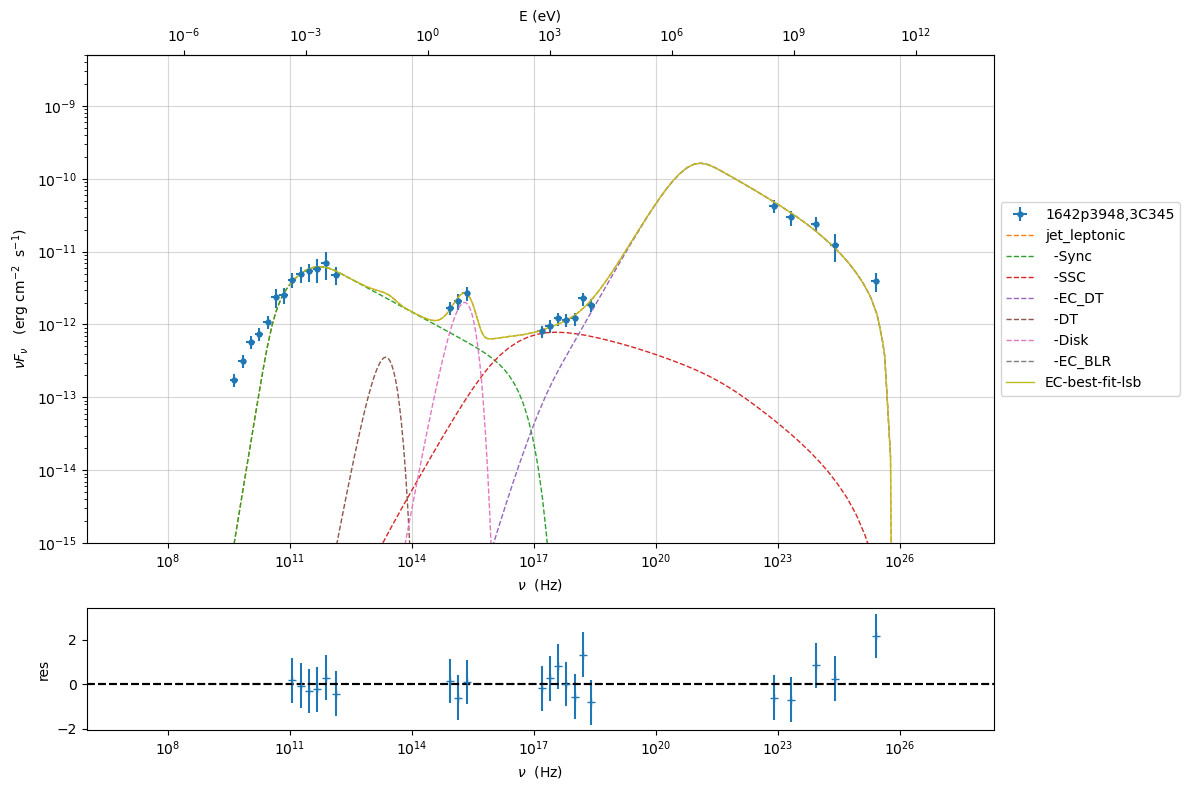

In [19]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,500)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-15,y_max=5E-9,x_min=1E6,x_max=2E28)

In [20]:
jet.energetic_report()

name,type,units,val
BulkLorentzFactor,,,1.069429e+01
U_e,Energy dens. blob rest. frame,erg / cm3,1.829260e-03
U_p_cold,Energy dens. blob rest. frame,erg / cm3,3.394356e-03
U_B,Energy dens. blob rest. frame,erg / cm3,6.471177e-04
U_p,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
U_p_target,Energy dens. blob rest. frame,erg / cm3,0.000000e+00
U_Synch,Energy dens. blob rest. frame,erg / cm3,1.927297e-04
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,2.520901e+00
U_Disk,Energy dens. blob rest. frame,erg / cm3,1.331209e-04
U_BLR,Energy dens. blob rest. frame,erg / cm3,3.467122e-11


In [21]:
best_fit_minuit.save_report('EC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('EC_model_minimizer_minuit.pkl')
fit_model.save_model('EC_fit_model_minuit.pkl')

## MCMC 

In [22]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer
model_minimizer_minuit = ModelMinimizer.load_model('EC_model_minimizer_minuit.pkl')


We  use a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used


In [23]:
mcmc=McmcSampler(model_minimizer_minuit)

labels=['N','B','beam_obj','p_1','gamma_break']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 277.30 seconds


In [24]:
print(mcmc.acceptance_fraction)

0.5128125


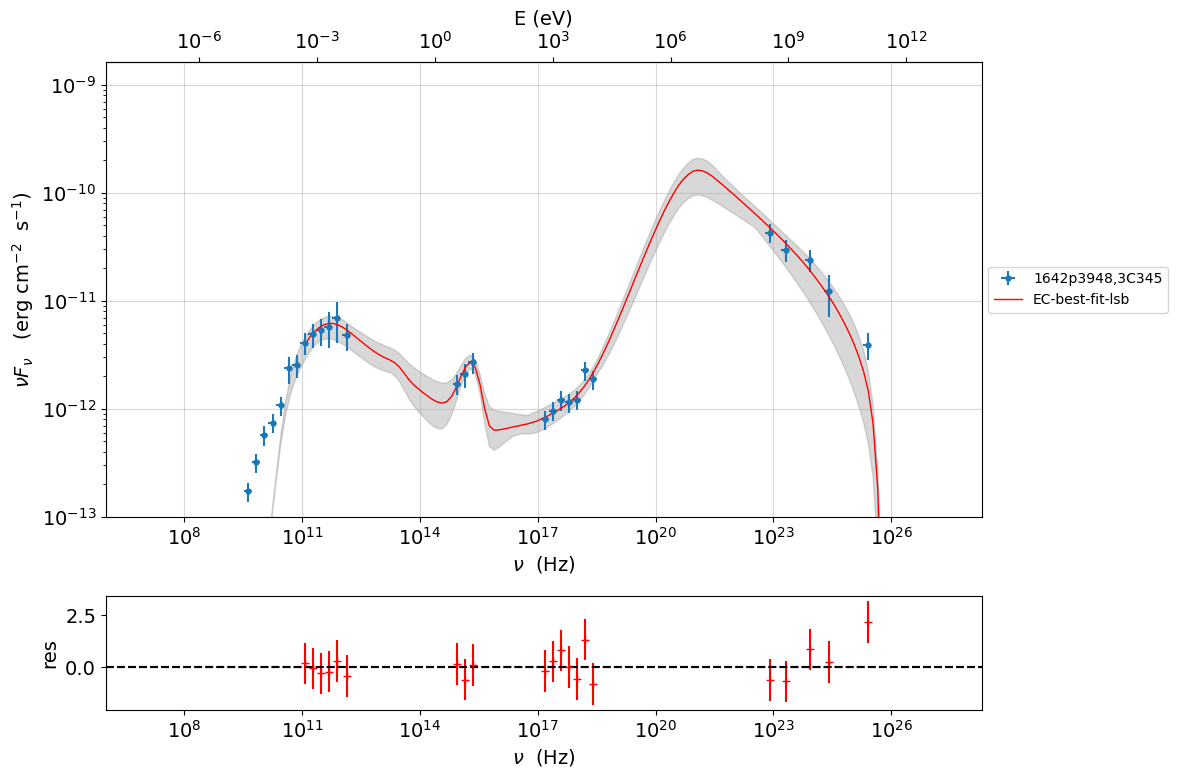

In [33]:
mcmc.model.set_nu_grid(1E6,1E30,200)

p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E11, 1E27],size=50)
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

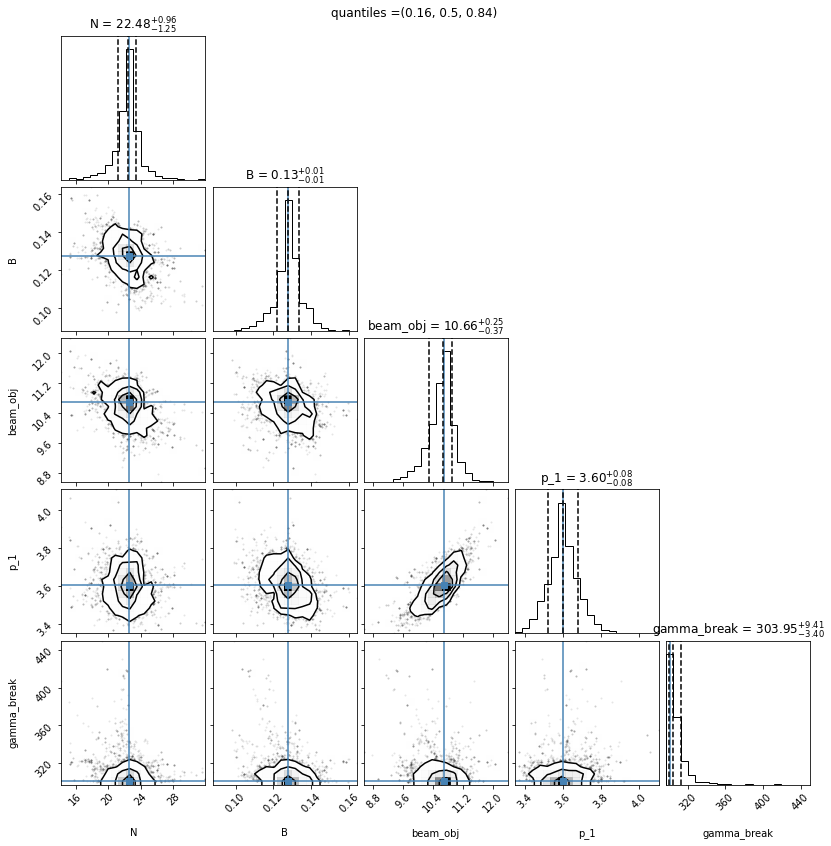

In [26]:
f=mcmc.corner_plot()

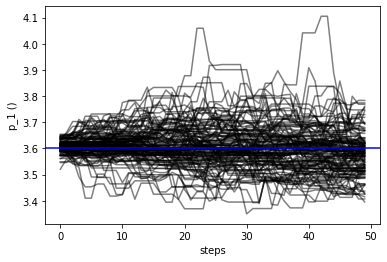

In [27]:
f=mcmc.plot_chain('p_1',log_plot=False)

## Save and reuse MCMC

In [28]:
mcmc.save('mcmc_sampler.pkl')

In [29]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('3C454_data.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

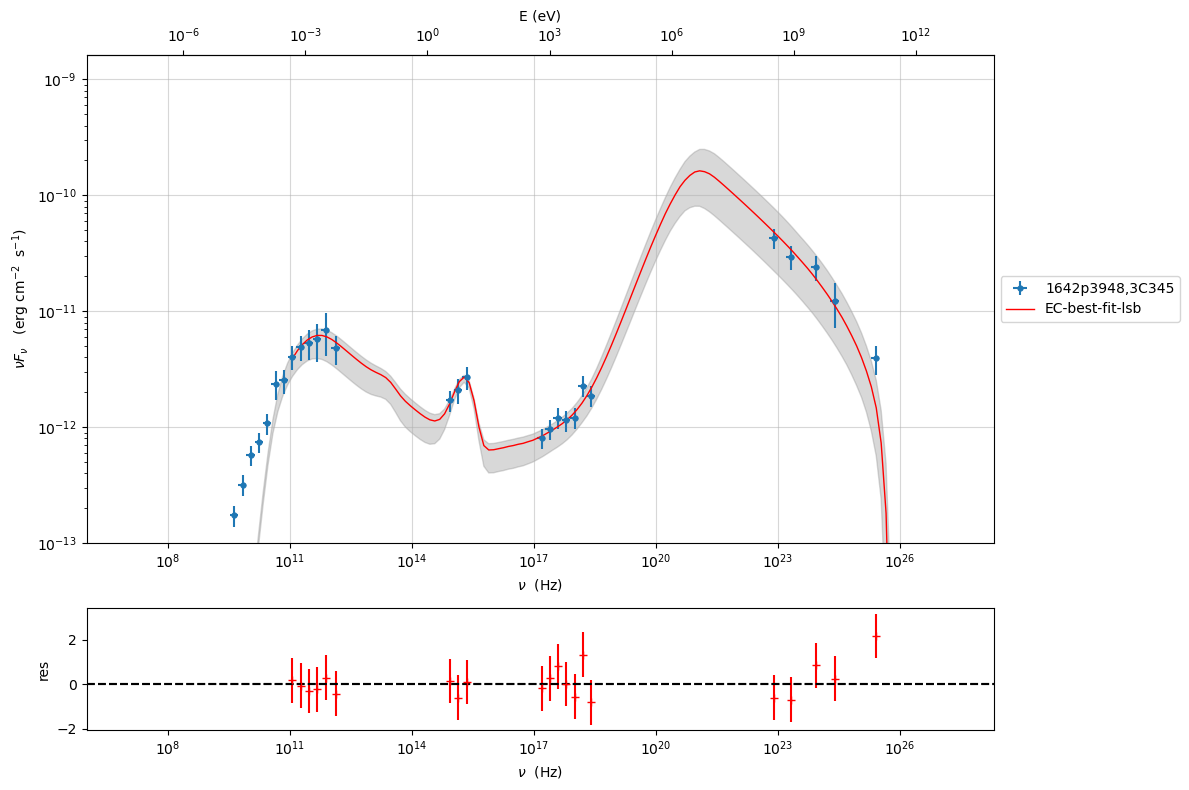

In [30]:
ms.model.set_nu_grid(1E6,1E30,200)

p=ms.plot_model(sed_data=sed_data,fit_range=[1E11, 1E27],size=50)
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

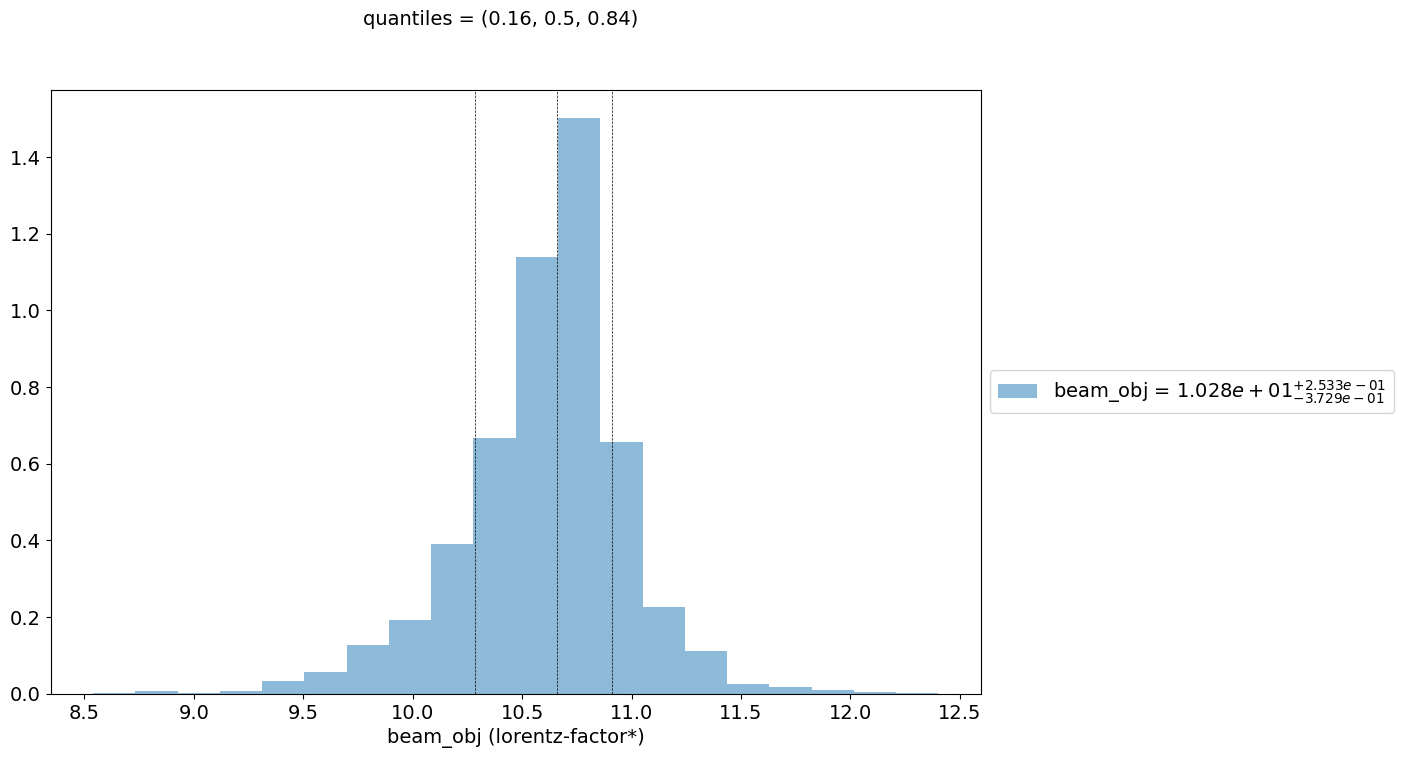

In [31]:
f=ms.plot_par('beam_obj',log_plot=False)


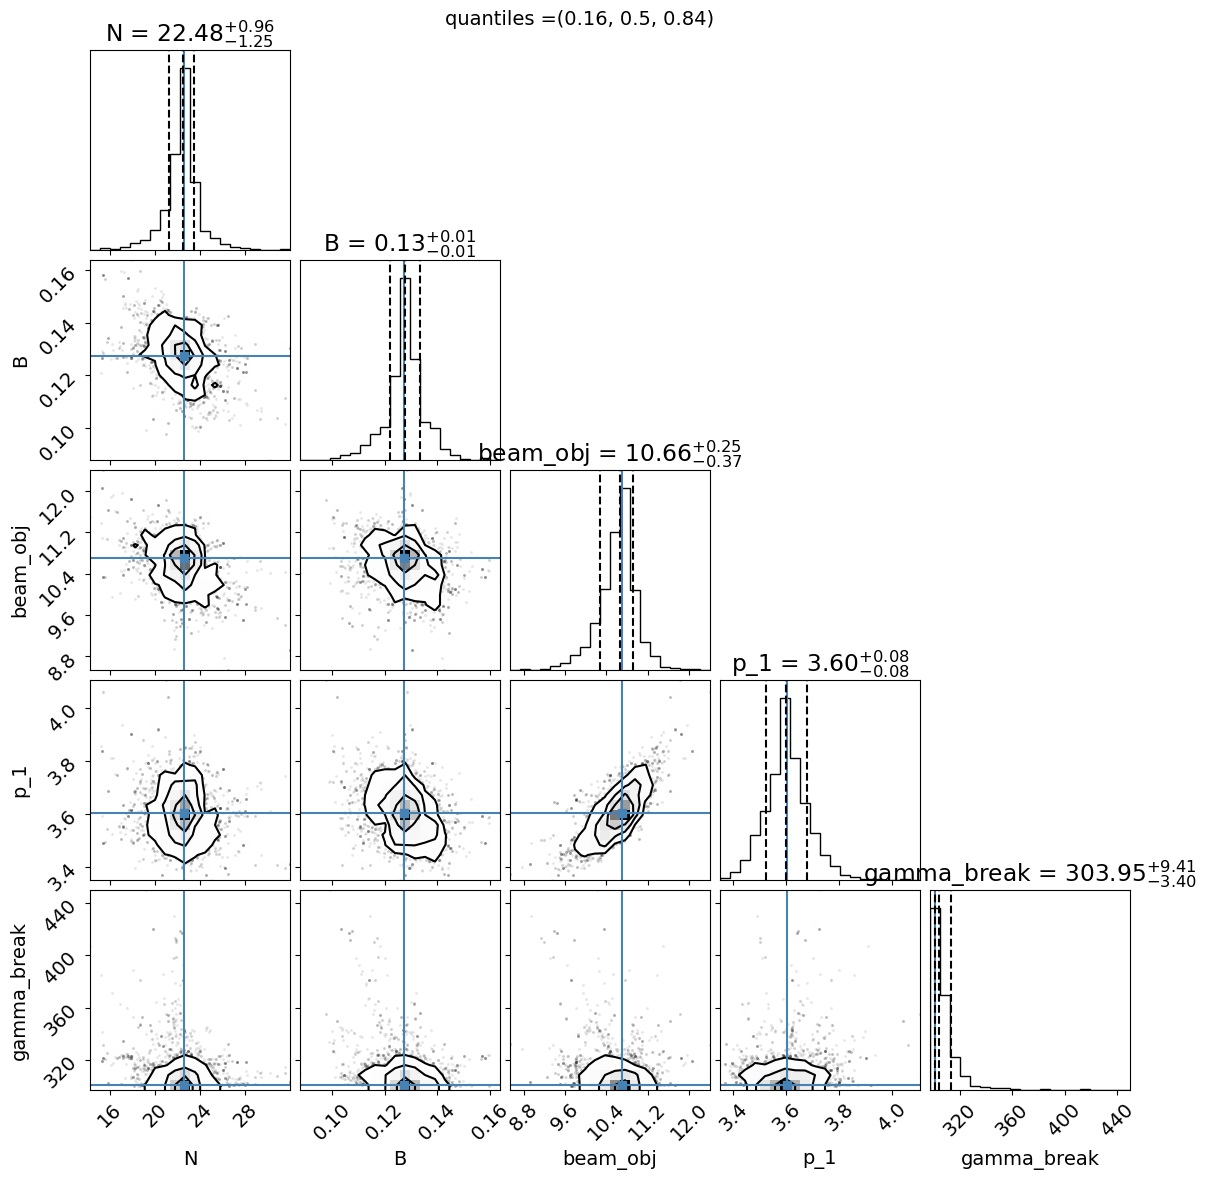

In [32]:
f=ms.corner_plot()